## Portafolio de 10 Empresas

En esta sección construiremos un portafolio configurable de 10 emisoras. Podrás cambiar la lista fácilmente en la primera celda de código. Para cada activo:

- Descargamos precios (close)
- Calculamos la estrategia SMA (rápida vs lenta) por defecto (21/63)
- Obtenemos métricas: Total Return, CAGR, Volatilidad anualizada, Sharpe, Max Drawdown, Calmar, Nº Trades, Win Rate, % Tiempo en Posición Larga, % Tiempo en Posición Corta
- Comparamos Buy & Hold vs Estrategia
- Construimos un portafolio equiponderado (Buy & Hold y Estrategia).

Puedes reemplazar los tickers en la lista `TICKERS` y re‑ejecutar desde ahí.

In [1]:
# Configuración inicial del portafolio
# Puedes cambiar libremente estos tickers (máximo o mínimo los que quieras)
TICKERS = [
    'AAPL.O', 'MSFT.O', 'NVDA.O', 'AMZN.O', 'META.O',
    'GOOGL.O', 'TSLA.O', 'NFLX.O', 'INTC.O', 'AMD.O'
]

# Parámetros de la estrategia de medias móviles
FAST_WINDOW = 21
SLOW_WINDOW = 63

# Capital inicial para métricas (no se usa en cálculo de retorno porcentual acumulado, solo para equity hipotético)
INITIAL_CAPITAL = 1_000_000

TICKERS

['AAPL.O',
 'MSFT.O',
 'NVDA.O',
 'AMZN.O',
 'META.O',
 'GOOGL.O',
 'TSLA.O',
 'NFLX.O',
 'INTC.O',
 'AMD.O']

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

@dataclass
class StrategyMetrics:
    ticker: str
    start: pd.Timestamp
    end: pd.Timestamp
    n_days: int
    total_return_bh: float
    total_return_strat: float
    cagr_bh: float
    cagr_strat: float
    vol_bh: float
    vol_strat: float
    sharpe_bh: float
    sharpe_strat: float
    max_dd_bh: float
    max_dd_strat: float
    calmar_bh: float
    calmar_strat: float
    trades: int
    win_rate: float
    pct_long: float
    pct_short: float


def max_drawdown(cum_returns: pd.Series) -> float:
    roll_max = cum_returns.cummax()
    dd = (cum_returns / roll_max) - 1.0
    return dd.min()


def cagr(total_return: float, n_days: int) -> float:
    years = n_days / 252
    if years <= 0:
        return np.nan
    return (1 + total_return) ** (1 / years) - 1


def annualized_vol(daily_returns: pd.Series) -> float:
    return daily_returns.std() * np.sqrt(252)


def sharpe_ratio(daily_returns: pd.Series, rf: float = 0.0) -> float:
    # rf asumido 0 para simplicidad
    vol = annualized_vol(daily_returns)
    if vol == 0 or np.isnan(vol):
        return np.nan
    return (daily_returns.mean() * 252 - rf) / vol


def build_sma_strategy(df: pd.DataFrame, fast: int, slow: int) -> pd.DataFrame:
    data = df.copy()
    data[f'SMA_{fast}'] = data['close'].rolling(fast).mean()
    data[f'SMA_{slow}'] = data['close'].rolling(slow).mean()
    data['position'] = np.where(data[f'SMA_{fast}'] > data[f'SMA_{slow}'], 1, -1)
    data['ret'] = np.log(data['close'] / data['close'].shift(1))
    data['strat_ret'] = data['position'].shift(1) * data['ret']
    data.dropna(inplace=True)
    return data


def count_trades(position_series: pd.Series) -> int:
    # Conteo de cambios de signo (ignora NaN inicial)
    pos = position_series.dropna()
    changes = (pos != pos.shift(1))
    return int(changes.sum())


def build_metrics(ticker: str, data: pd.DataFrame) -> StrategyMetrics:
    cum_bh = data['ret'].cumsum().apply(np.exp)
    cum_strat = data['strat_ret'].cumsum().apply(np.exp)
    total_return_bh = cum_bh.iloc[-1] - 1
    total_return_strat = cum_strat.iloc[-1] - 1
    n_days = data.shape[0]

    cagr_b = cagr(total_return_bh, n_days)
    cagr_s = cagr(total_return_strat, n_days)
    vol_b = annualized_vol(data['ret'])
    vol_s = annualized_vol(data['strat_ret'])
    sharpe_b = sharpe_ratio(data['ret'])
    sharpe_s = sharpe_ratio(data['strat_ret'])
    max_dd_b = max_drawdown(cum_bh)
    max_dd_s = max_drawdown(cum_strat)
    calmar_b = np.nan if max_dd_b == 0 else cagr_b / abs(max_dd_b)
    calmar_s = np.nan if max_dd_s == 0 else cagr_s / abs(max_dd_s)
    trades = count_trades(data['position'])

    # Win rate: porcentaje de días con retorno de estrategia > 0
    win_rate = (data['strat_ret'] > 0).mean()
    pct_long = (data['position'] == 1).mean()
    pct_short = (data['position'] == -1).mean()

    return StrategyMetrics(
        ticker=ticker,
        start=data.index[0],
        end=data.index[-1],
        n_days=n_days,
        total_return_bh=total_return_bh,
        total_return_strat=total_return_strat,
        cagr_bh=cagr_b,
        cagr_strat=cagr_s,
        vol_bh=vol_b,
        vol_strat=vol_s,
        sharpe_bh=sharpe_b,
        sharpe_strat=sharpe_s,
        max_dd_bh=max_dd_b,
        max_dd_strat=max_dd_s,
        calmar_bh=calmar_b,
        calmar_strat=calmar_s,
        trades=trades,
        win_rate=win_rate,
        pct_long=pct_long,
        pct_short=pct_short
    )


def metrics_to_frame(metrics_list):
    rows = []
    for m in metrics_list:
        rows.append({
            'Ticker': m.ticker,
            'Start': m.start.date(),
            'End': m.end.date(),
            'Días': m.n_days,
            'TotRet_BH': m.total_return_bh,
            'TotRet_Strat': m.total_return_strat,
            'CAGR_BH': m.cagr_bh,
            'CAGR_Strat': m.cagr_strat,
            'Vol_BH': m.vol_bh,
            'Vol_Strat': m.vol_strat,
            'Sharpe_BH': m.sharpe_bh,
            'Sharpe_Strat': m.sharpe_strat,
            'MaxDD_BH': m.max_dd_bh,
            'MaxDD_Strat': m.max_dd_strat,
            'Calmar_BH': m.calmar_bh,
            'Calmar_Strat': m.calmar_strat,
            'Trades': m.trades,
            'WinRate': m.win_rate,
            'Pct_Long': m.pct_long,
            'Pct_Short': m.pct_short
        })
    dfm = pd.DataFrame(rows)
    cols_pct = ['TotRet_BH','TotRet_Strat','CAGR_BH','CAGR_Strat','MaxDD_BH','MaxDD_Strat']
    # Formato rápido (se puede estilizar después)
    return dfm

In [3]:
from datafromsource import DataFromSource

all_data = {}
metrics_list = []

for tk in TICKERS:
    src = DataFromSource(tk)
    raw = src.get_prices()
    strat_df = build_sma_strategy(raw, FAST_WINDOW, SLOW_WINDOW)
    m = build_metrics(tk, strat_df)
    metrics_list.append(m)
    all_data[tk] = strat_df

metrics_df = metrics_to_frame(metrics_list)
metrics_df = metrics_df.sort_values('CAGR_Strat', ascending=False).reset_index(drop=True)

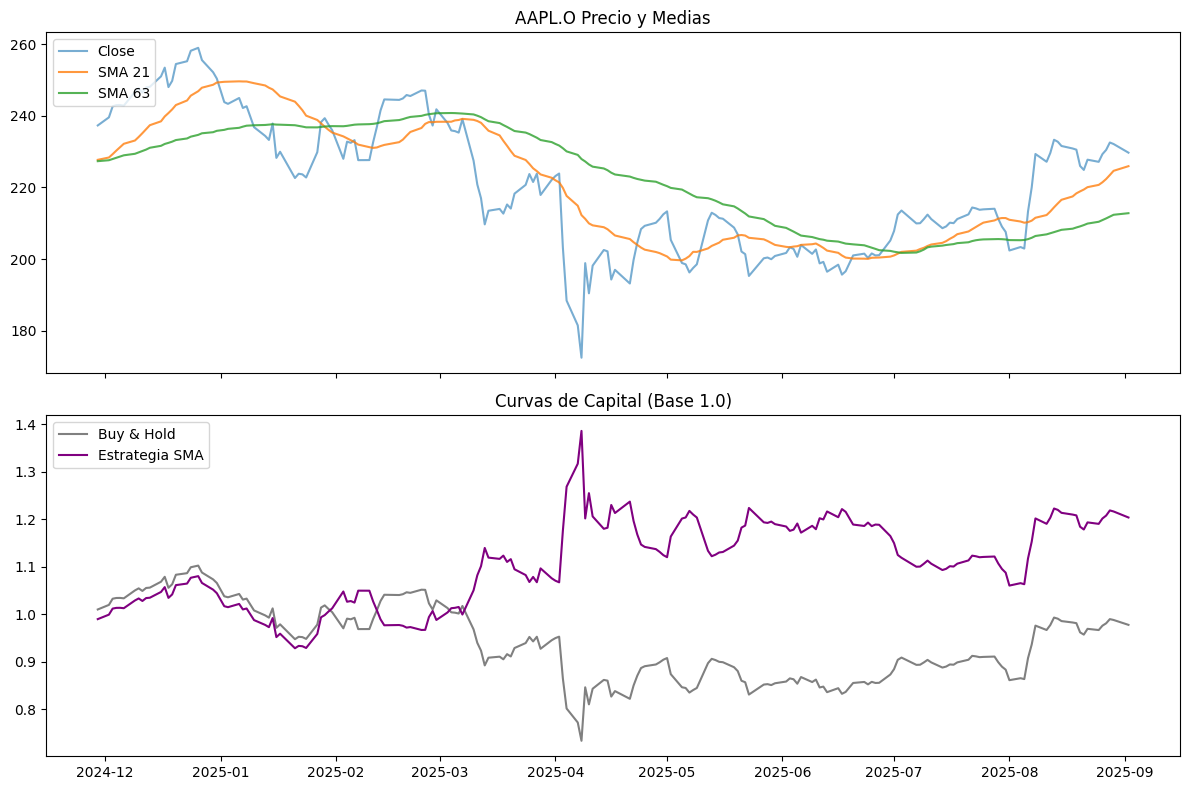

,Ticker,Start,End,Días,TotRet_BH,TotRet_Strat,CAGR_BH,CAGR_Strat,Vol_BH,Vol_Strat,Sharpe_BH,Sharpe_Strat,MaxDD_BH,MaxDD_Strat,Calmar_BH,Calmar_Strat,Trades,WinRate,Pct_Long,Pct_Short
3,AAPL.O,2024-11-29,2025-09-02,188,-0.022177,0.203749,-0.029614,0.28219,0.349088,0.34874,-0.086113,0.712766,-0.334337,-0.234833,-0.088574,1.201663,3,0.5,0.430851,0.569149


In [4]:
# Visualización para un ticker específico
TICKER_VIEW = 'AAPL.O'  # cambia este valor para ver otro

dv = all_data[TICKER_VIEW]
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
axes[0].plot(dv.index, dv['close'], label='Close', alpha=0.6)
axes[0].plot(dv.index, dv[f'SMA_{FAST_WINDOW}'], label=f'SMA {FAST_WINDOW}', alpha=0.8)
axes[0].plot(dv.index, dv[f'SMA_{SLOW_WINDOW}'], label=f'SMA {SLOW_WINDOW}', alpha=0.8)
axes[0].set_title(f'{TICKER_VIEW} Precio y Medias')
axes[0].legend(loc='upper left')

cum_bh = dv['ret'].cumsum().apply(np.exp)
cum_str = dv['strat_ret'].cumsum().apply(np.exp)
axes[1].plot(cum_bh.index, cum_bh, label='Buy & Hold', color='gray')
axes[1].plot(cum_str.index, cum_str, label='Estrategia SMA', color='purple')
axes[1].set_title('Curvas de Capital (Base 1.0)')
axes[1].legend(loc='upper left')
plt.tight_layout()
plt.show()

metrics_df[metrics_df['Ticker'] == TICKER_VIEW]

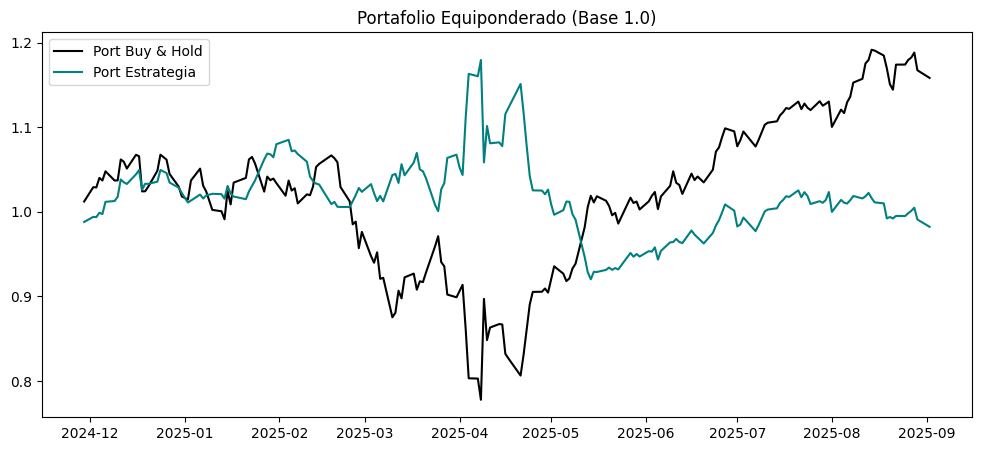

{'TotRet_BH': np.float64(0.158286187907124),
 'TotRet_Strat': np.float64(-0.017733126178820946),
 'CAGR_BH': np.float64(0.21770035223474227),
 'CAGR_Strat': np.float64(-0.023697906008782632),
 'Vol_BH': np.float64(0.3244888138274177),
 'Vol_Strat': np.float64(0.2433428037859039),
 'Sharpe_BH': np.float64(0.6069981903840678),
 'Sharpe_Strat': np.float64(-0.09855733375364988),
 'MaxDD_BH': np.float64(-0.27141084888747613),
 'MaxDD_Strat': np.float64(-0.2198462570944325)}

In [5]:
# Portafolio equiponderado
# Alineamos retornos diarios de cada activo
rets_bh = []
rets_str = []
for tk, dfv in all_data.items():
    rets_bh.append(dfv['ret'].rename(tk))
    rets_str.append(dfv['strat_ret'].rename(tk))

rets_bh = pd.concat(rets_bh, axis=1).dropna(how='all')
rets_str = pd.concat(rets_str, axis=1).reindex(index=rets_bh.index).fillna(0)

# Promedio simple (equiponderado)
port_ret_bh = rets_bh.mean(axis=1)
port_ret_str = rets_str.mean(axis=1)

cum_bh_port = port_ret_bh.cumsum().apply(np.exp)
cum_str_port = port_ret_str.cumsum().apply(np.exp)

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(cum_bh_port, label='Port Buy & Hold', color='black')
ax.plot(cum_str_port, label='Port Estrategia', color='teal')
ax.set_title('Portafolio Equiponderado (Base 1.0)')
ax.legend()
plt.show()

# Métricas agregadas del portafolio
port_metrics = {
    'TotRet_BH': cum_bh_port.iloc[-1]-1,
    'TotRet_Strat': cum_str_port.iloc[-1]-1,
    'CAGR_BH': cagr(cum_bh_port.iloc[-1]-1, len(cum_bh_port)),
    'CAGR_Strat': cagr(cum_str_port.iloc[-1]-1, len(cum_str_port)),
    'Vol_BH': annualized_vol(port_ret_bh),
    'Vol_Strat': annualized_vol(port_ret_str),
    'Sharpe_BH': sharpe_ratio(port_ret_bh),
    'Sharpe_Strat': sharpe_ratio(port_ret_str),
    'MaxDD_BH': max_drawdown(cum_bh_port),
    'MaxDD_Strat': max_drawdown(cum_str_port),
}
port_metrics

### Notas y Personalización

- Para cambiar emisoras, edita la lista `TICKERS` y re‑ejecuta desde esa celda.
- Puedes ajustar ventanas `FAST_WINDOW` y `SLOW_WINDOW`.
- Agrega otras reglas (RSI, MAMA, etc.) creando nuevas funciones similares a `build_sma_strategy`.
- Para ponderaciones distintas (por ejemplo basadas en volatilidad inversa), reemplaza el promedio simple por un vector de pesos.
- Para incluir costos de transacción: multiplica `strat_ret` por `(1 - cost)` en días de cambio de posición.

Siguientes ideas:
1. Optimización de ventanas via grid search.
2. Filtrar trades con volatilidad anormal.
3. Incorporar stop-loss y take-profit.
4. Evaluar correlaciones y diversificación efectiva (N efectivo = 1 / sum w_i^2).
5. Exportar resultados a CSV: `metrics_df.to_csv('metrics_individuales.csv', index=False)`.

Listo para tus modificaciones.

### Señales vs Predicción

Las reglas que implementamos (cruce de medias, MAMA, etc.) NO "predicen" el futuro; generan **señales reactivas** basadas en precios ya observados. Una señal de compra aparece cuando la media rápida supera a la lenta (cambio de tendencia reciente), no porque sepamos que subirá después. 

Para intentar predecir (en sentido estadístico) necesitarías modelos de pronóstico (ARIMA, Prophet, LSTM, factores macro, etc.) y siempre habrá incertidumbre. Las reglas técnicas:
- Filtran ruido para entrar cuando hay momentum / tendencia.
- Reducen subjetividad.
- Pueden fallar en mercados laterales (whipsaw).

Por eso medimos desempeño histórico (backtest) para ver **cómo habría funcionado**, no para garantizar resultados futuros.

A continuación integramos la parte esencial de Markowitz para optimizar pesos del portafolio usando los retornos diarios (Buy & Hold o Estrategia).

In [6]:
# --- Preparación datos para Markowitz ---
# Usa retornos de la estrategia o Buy & Hold. Cambia USE_STRATEGY = True/False
USE_STRATEGY = True

rets_for_mkv = []
for tk, d in all_data.items():
    col = 'strat_ret' if USE_STRATEGY else 'ret'
    rets_for_mkv.append(d[col].rename(tk))

returns_mkv = pd.concat(rets_for_mkv, axis=1).dropna()
returns_mkv.head()

,AAPL.O,MSFT.O,NVDA.O,AMZN.O,META.O,GOOGL.O,TSLA.O,NFLX.O,INTC.O,AMD.O
Date,,,,,,,,,,
2024-11-29,-0.010164,-0.001111,-0.021274,-0.010396,-0.008955,0.001656,-0.036196,-0.010736,-0.016772,-0.006839
2024-12-02,0.009478,-0.017603,0.002745,0.013474,0.031721,0.014922,0.033980,0.012250,-0.005002,-0.034992
2024-12-03,0.012691,-0.000510,0.011689,0.012873,0.034517,-0.000875,-0.016006,0.004922,-0.062952,0.000563
2024-12-04,0.001483,-0.014322,0.034201,0.021873,0.000212,0.017530,0.018355,0.009806,-0.022958,-0.014058
2024-12-05,0.000123,-0.011818,-0.000551,0.010896,-0.007933,-0.009971,0.031786,0.007447,-0.054270,0.018434


In [7]:
import numpy as np
from scipy.optimize import minimize

periods_per_year = 252
mean_daily = returns_mkv.mean()
cov_daily = returns_mkv.cov()
mean_annual = mean_daily * periods_per_year
cov_annual = cov_daily * periods_per_year
rf = 0.0  # Ajusta si tienes tasa libre de riesgo
n_assets = returns_mkv.shape[1]

# Funciones

def portfolio_perf(weights, mean_ret=mean_annual, cov=cov_annual, rf=rf):
    ret = np.dot(weights, mean_ret)
    vol = np.sqrt(weights @ cov @ weights)
    sharpe = (ret - rf) / vol if vol > 0 else np.nan
    return ret, vol, sharpe

def max_sharpe(short=False):
    bounds = ((-1,1) if short else (0,1),) * n_assets
    x0 = np.full(n_assets, 1/n_assets)
    cons = ({'type':'eq','fun':lambda w: np.sum(w)-1})
    def neg_sharpe(w):
        return -portfolio_perf(w)[2]
    res = minimize(neg_sharpe, x0, method='SLSQP', bounds=bounds, constraints=cons)
    return res

def min_vol(short=False):
    bounds = ((-1,1) if short else (0,1),) * n_assets
    x0 = np.full(n_assets, 1/n_assets)
    cons = ({'type':'eq','fun':lambda w: np.sum(w)-1})
    def vol(w):
        return portfolio_perf(w)[1]
    res = minimize(vol, x0, method='SLSQP', bounds=bounds, constraints=cons)
    return res

def efficient_frontier(target_returns, short=False):
    bounds = ((-1,1) if short else (0,1),) * n_assets
    x0 = np.full(n_assets, 1/n_assets)
    cons_base = ({'type':'eq','fun':lambda w: np.sum(w)-1},)
    ef_points = []
    for tr in target_returns:
        cons = cons_base + ({'type':'eq','fun':lambda w, tr=tr: np.dot(w, mean_annual)-tr},)
        res = minimize(lambda w: np.sqrt(w @ cov_annual @ w), x0, method='SLSQP', bounds=bounds, constraints=cons)
        if res.success:
            r,v,_ = portfolio_perf(res.x)
            ef_points.append((r,v,res.x))
    return ef_points

# Ejecutar optimizaciones
res_ms = max_sharpe(short=False)
res_mv = min_vol(short=False)

ret_ms, vol_ms, sr_ms = portfolio_perf(res_ms.x)
ret_mv, vol_mv, sr_mv = portfolio_perf(res_mv.x)

print('Max Sharpe -> Ret: {:.2%} Vol: {:.2%} Sharpe: {:.2f}'.format(ret_ms, vol_ms, sr_ms))
print('Min Vol    -> Ret: {:.2%} Vol: {:.2%} Sharpe: {:.2f}'.format(ret_mv, vol_mv, sr_mv))

Max Sharpe -> Ret: 52.72% Vol: 38.37% Sharpe: 1.37
Min Vol    -> Ret: -25.22% Vol: 17.63% Sharpe: -1.43


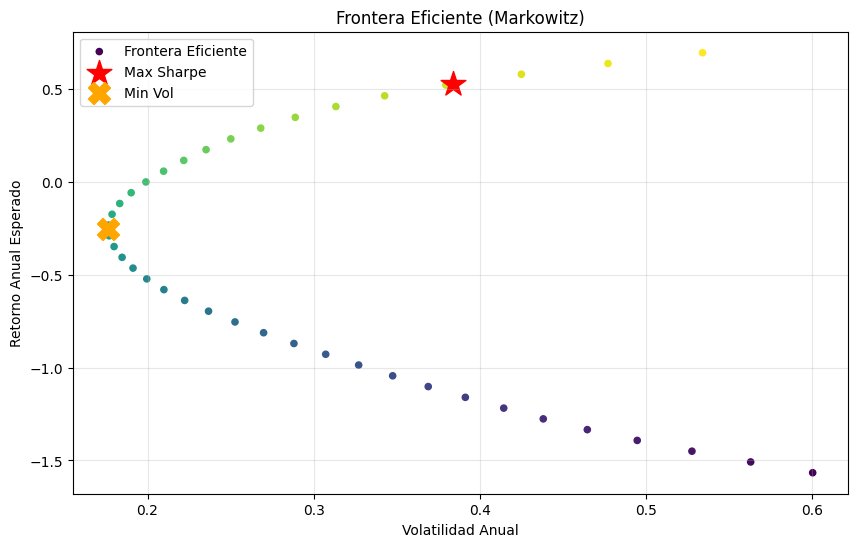

,Peso_MaxSharpe,Peso_MinVol
Activo,,
AAPL.O,5.015667e-16,0.055947
MSFT.O,5.024190e-16,0.368292
NVDA.O,1.924321e-16,0.042205
AMZN.O,0.000000e+00,0.000000
META.O,0.000000e+00,0.000000
GOOGL.O,3.905029e-01,0.133947
TSLA.O,0.000000e+00,0.000000
NFLX.O,0.000000e+00,0.216049
INTC.O,1.034118e-15,0.183560


In [8]:
# Frontera eficiente
tr_min, tr_max = mean_annual.min(), mean_annual.max()
target_grid = np.linspace(tr_min, tr_max, 40)
frontier = efficient_frontier(target_grid, short=False)

# Preparar datos
fr_ret = [p[0] for p in frontier]
fr_vol = [p[1] for p in frontier]

plt.figure(figsize=(10,6))
plt.scatter(fr_vol, fr_ret, s=20, c=fr_ret, cmap='viridis', label='Frontera Eficiente')
plt.scatter(vol_ms, ret_ms, marker='*', s=350, c='red', label='Max Sharpe')
plt.scatter(vol_mv, ret_mv, marker='X', s=250, c='orange', label='Min Vol')
plt.xlabel('Volatilidad Anual')
plt.ylabel('Retorno Anual Esperado')
plt.title('Frontera Eficiente (Markowitz)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Pesos
weights_df = pd.DataFrame({
    'Activo': returns_mkv.columns,
    'Peso_MaxSharpe': res_ms.x,
    'Peso_MinVol': res_mv.x
}).set_index('Activo')
weights_df

### Interpretación Práctica

1. Pesos de Markowitz: Los pesos Max Sharpe maximizan (Retorno - rf) / Vol. Úsalos como proporciones de capital. Rebalancea periódicamente (ej. mensual o trimestral) para aproximarte al perfil calculado.
2. Señales Técnicas: Dentro de cada activo puedes aplicar la señal (posición +1 / -1) para modular la exposición. Ejemplo: Peso teórico * Señal = Exposición efectiva.
3. Riesgo: Verifica concentración (suma de pesos grandes). Puedes imponer límites agregando restricciones en la optimización.
4. No es predicción: Los pesos reflejan media y covarianza históricas. Si el régimen de mercado cambia, los parámetros deben recalibrarse.
5. Próximos pasos: Añadir costos, límites (mín-max por activo), control de turnover, y usar retornos esperados ajustados (factor models o blended forecasts).

Con esto tienes: (a) Generación de señales reactivas por activo y (b) Asignación óptima de capital cruzado. Listo para experimentar.